# Image Deblurring - June Exam

# Assignment
## Task 

The task consists of creating a deep learning model to detect hate speech or offensive language in texts. 

Try to build a pipeline which is able to perform the task and evaluate the results obtained. 

## Dataset
The dataset is built starting from *CIFAR-10* images collection. Feel free to further split the data to build a validation set, if needed. 

The split into different data split is left to you, perform it as you like, making sure it is meaningful.

### Dataset creation - DO NOT MODIFY

In [2]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

def getDataset():
    (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
    normalize = lambda x: x/x.max()
    x_train = normalize(x_train)
    x_test = normalize(x_test)
    createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
    return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Structure

Write a notebook explaining every step you take in the building of the pipeline and **DON'T** clear the output of the cells when you submit it.  

Make sure to test the model in order to prove robustness and lack of overfitting.

The metric you will need to use to evaluate the results is the *MSE*.

## Hints and requirements

There are different strategies to remove such noise from images, feel free to use the one you consider to be the most appropriate, keeping in mind that the blurring is Gaussian and so is the noise. 

The metrics will be evaluated on the reconstructed images, so provide a way to check the results on a batch composed of original images and reconstructed images.

You can't use **ANY** pre-trained models for this exam and try to build models with less than 10 milions trainable parameters. 

Try to remember all the instructions we provided in the last lab lesson about the submission, make sure to output the metrics of your final model and use the adequate strategy for the task. 

Save the weights of your model and keep them until the discussion, we might ask you to provide them. 

# Solution
## Data visualization


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

%matplotlib inline

In [5]:
(x_train, y_train), (x_test, y_test) = getDataset()

In [6]:
print(f'The shape of the x_train dataset is: {x_train.shape}')
print(f'The shape of the y_train dataset is: {y_train.shape}')

print(f'The shape of the x_test dataset is: {x_test.shape}')
print(f'The shape of the y_test dataset is: {y_test.shape}')

The shape of the x_train dataset is: (50000, 32, 32, 3)
The shape of the y_train dataset is: (50000, 32, 32, 3)
The shape of the x_test dataset is: (10000, 32, 32, 3)
The shape of the y_test dataset is: (10000, 32, 32, 3)


In [7]:
# y_train.max()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


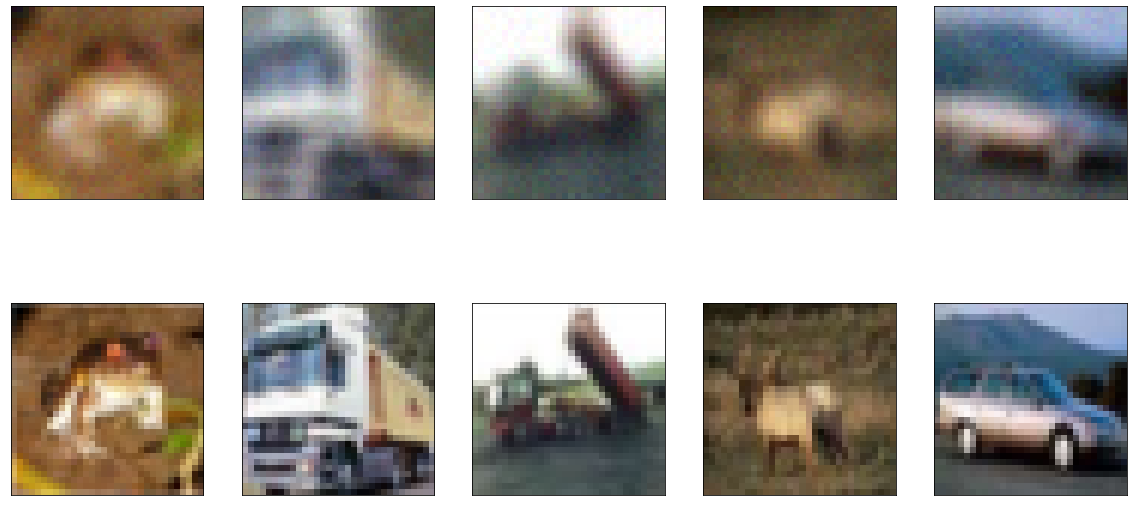

In [8]:
def plot_first_images(n_images_to_plot=5):
    plt.figure(figsize=(20, 10))
    for i in range(n_images_to_plot):
        # Display blurrd image
        ax = plt.subplot(2, n_images_to_plot, i + 1)
        plt.imshow(x_train[i], vmin=0., vmax=1.)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed image
        ax = plt.subplot(2, n_images_to_plot, i + 1 + n_images_to_plot)
        plt.imshow(y_train[i], vmin=0., vmax=1.)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
plot_first_images()

In [19]:
initializer = tf.keras.initializers.RandomNormal(stddev=0.01)

def EAM(input):
    x=layers.Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')(input)
    x=layers.Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu')(x)

    y=layers.Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')(input)
    y=layers.Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')(y)

    z=layers.Concatenate(axis=-1)([x,y])
    z=layers.Conv2D(64, (3,3),padding='same',activation='relu')(z)
    add_1=layers.Add()([z, input])

    z=layers.Conv2D(64, (3,3),padding='same', activation='relu')(add_1)
    z=layers.Conv2D(64, (3,3),padding='same')(z)
    add_2=layers.Add()([z,add_1])
    add_2 = layers.Activation('relu')(add_2)

    z=layers.Conv2D(64, (3,3),padding='same',activation='relu')(add_2)
    z=layers.Conv2D(64, (3,3),padding='same',activation='relu')(z)
    z=layers.Conv2D(64, (1,1),padding='same')(z)
    add_3=layers.Add()([z,add_2])
    add_3 = layers.Activation('relu')(add_3)

    z = layers.GlobalAveragePooling2D(keepdims=True)(add_3)
    #z = tf.expand_dims(z,1)
    #z = tf.expand_dims(z,1)
    z=layers.Conv2D(4, (3,3),padding='same',activation='relu')(z)
      # add Conv2D 64 3x3 padding same relu
    z=layers.Conv2D(64, (3,3),padding='same',activation='sigmoid')(z)
    mul=layers.Multiply()([z, add_3])

    return mul

def RIDNET(input_shape):
    input = layers.Input(input_shape, name='input')
    feat_extraction = layers.Conv2D(64, (3,3),padding='same')(input)
    eam_1=EAM(feat_extraction)
    eam_2=EAM(eam_1)
    eam_3=EAM(eam_2)
    eam_4=EAM(eam_3)
    x = layers.Conv2D(3, (3,3),padding='same')(eam_4)
    add_2 = layers.Add()([x, input])
  
    model=Model(input,add_2)

    return model

autoencoder = RIDNET(x_train.shape[1:])

In [20]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_58 (Conv2D)             (None, 32, 32, 64)   1792        ['input[0][0]']                  
                                                                                                  
 conv2d_59 (Conv2D)             (None, 32, 32, 64)   36928       ['conv2d_58[0][0]']              
                                                                                                  
 conv2d_61 (Conv2D)             (None, 32, 32, 64)   36928       ['conv2d_58[0][0]']              
                                                                                            

 conv2d_80 (Conv2D)             (None, 32, 32, 64)   4160        ['conv2d_79[0][0]']              
                                                                                                  
 add_20 (Add)                   (None, 32, 32, 64)   0           ['conv2d_80[0][0]',              
                                                                  'activation_10[0][0]']          
                                                                                                  
 activation_11 (Activation)     (None, 32, 32, 64)   0           ['add_20[0][0]']                 
                                                                                                  
 global_average_pooling2d_5 (Gl  (None, 1, 1, 64)    0           ['activation_11[0][0]']          
 obalAveragePooling2D)                                                                            
                                                                                                  
 conv2d_81

 conv2d_101 (Conv2D)            (None, 32, 32, 64)   36928       ['conv2d_100[0][0]']             
                                                                                                  
 add_25 (Add)                   (None, 32, 32, 64)   0           ['conv2d_101[0][0]',             
                                                                  'add_24[0][0]']                 
                                                                                                  
 activation_14 (Activation)     (None, 32, 32, 64)   0           ['add_25[0][0]']                 
                                                                                                  
 conv2d_102 (Conv2D)            (None, 32, 32, 64)   36928       ['activation_14[0][0]']          
                                                                                                  
 conv2d_103 (Conv2D)            (None, 32, 32, 64)   36928       ['conv2d_102[0][0]']             
          

https://github.com/jyothishkjames/Image-Denoising-with-Autoencoders/blob/master/models/train_model.py

https://medium.com/analytics-vidhya/noise-removal-in-images-using-deep-learning-models-3972544372d2

In [21]:
tf.norm(x_train[0:4] - x_train[0:4], ord=1, axis=-1)

<tf.Tensor: shape=(4, 32, 32), dtype=float64, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0

In [22]:
tf.keras.metrics.mean_squared_error(x_train[0:20], x_train[0:20])

<tf.Tensor: shape=(20, 32, 32), dtype=float64, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [23]:
one_norm_loss = lambda y_true, y_pred: tf.norm(y_true - y_pred, ord=1, axis=-1)

In [24]:
from tensorflow.keras.optimizers import Adam
adam = Adam(0.001, beta_1=0.1)
autoencoder.compile(optimizer=adam, loss=one_norm_loss, metrics=["mse"])

In [25]:
autoencoder.fit(x_train, y_train,
                validation_split=0.2,
                epochs=20,
                batch_size=128)

Epoch 1/20
625/625 [==============================] - 139s 217ms/step - loss: 0.1383 - mse: 0.0043 - val_loss: 0.1253 - val_mse: 0.0035
Epoch 2/20
625/625 [==============================] - 135s 216ms/step - loss: 0.1179 - mse: 0.0030 - val_loss: 0.1114 - val_mse: 0.0027
Epoch 3/20
625/625 [==============================] - 135s 216ms/step - loss: 0.1091 - mse: 0.0027 - val_loss: 0.1040 - val_mse: 0.0024
Epoch 4/20
625/625 [==============================] - 135s 216ms/step - loss: 0.1038 - mse: 0.0025 - val_loss: 0.1003 - val_mse: 0.0023
Epoch 5/20
625/625 [==============================] - 135s 216ms/step - loss: 0.1020 - mse: 0.0024 - val_loss: 0.0994 - val_mse: 0.0023
Epoch 6/20
625/625 [==============================] - 135s 216ms/step - loss: 0.1004 - mse: 0.0023 - val_loss: 0.1014 - val_mse: 0.0024
Epoch 7/20
625/625 [==============================] - 135s 216ms/step - loss: 0.0992 - mse: 0.0023 - val_loss: 0.1000 - val_mse: 0.0023
Epoch 8/20
625/625 [============================

In [ ]:
#from sklearn.metrics import mean_squared_error

In [26]:
predictions = autoencoder.predict(x_test)

313/313 [==============================] - 12s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


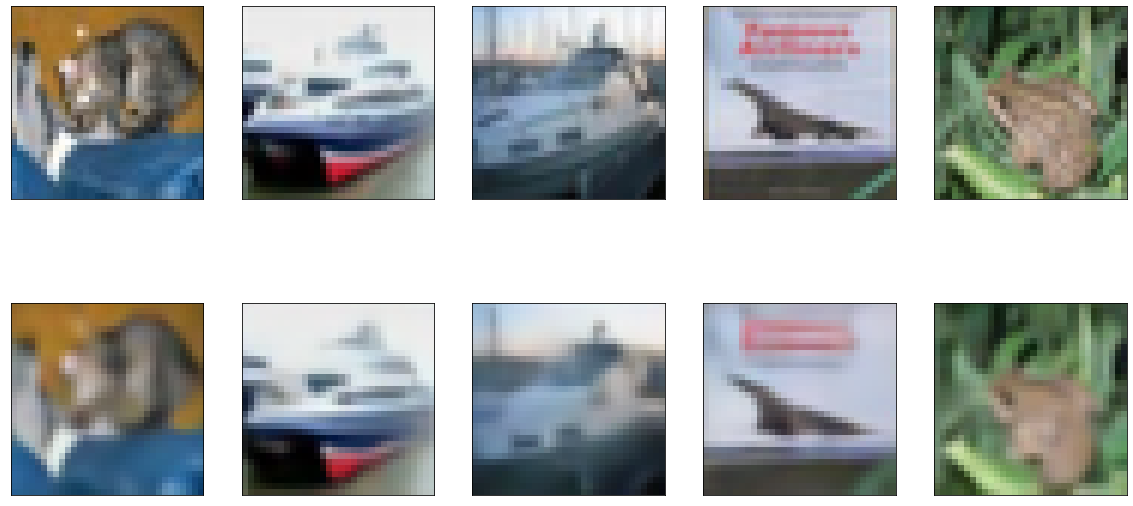

In [29]:
def plot_first_predicted_images(n_images_to_plot=5):
    plt.figure(figsize=(20, 10))
    for i in range(n_images_to_plot):
        # Display actual image
        ax = plt.subplot(2, n_images_to_plot, i + 1)
        plt.imshow(y_test[i], vmin=0., vmax=1.)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display predicted image
        ax = plt.subplot(2, n_images_to_plot, i + 1 + n_images_to_plot)
        plt.imshow(predictions[i], vmin=0., vmax=1.)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()
plot_first_predicted_images()

In [30]:
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, predictions).numpy()

0.0021835747